In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from forex_python.converter import CurrencyRates
from pypfopt import EfficientFrontier, plotting
import math
import scipy.optimize as sco

In [6]:
portfolio = ['ECOPETROL.CL', 'GEB.CL', 'PFCIBEST.CL', 'CIBEST.CL', 'GOOGL', 'AAPL', 'BVC.CL', 'NKE','IVV']
stocks_en_usd = ['AAPL', 'IVV', 'GOOGL', 'NKE'] 

In [7]:
def descargar_precios(portfolio, start_date, end_date, stocks_en_usd):
    """
    Descarga precios y convierte USD a COP
    """
    stock_prices = pd.DataFrame()
    
    # Descargar precios de acciones
    for ticker in portfolio:
        stock = yf.Ticker(ticker)
        close_price = stock.history(start=start_date, end=end_date)['Close']
        stock_prices = pd.concat([stock_prices, close_price], axis=1)
    
    stock_prices.columns = portfolio
    
    # Descargar tipo de cambio USD/COP
    usd_cop = yf.Ticker("COP=X").history(start=start_date, end=end_date)['Close']
    usd_cop = usd_cop.reindex(stock_prices.index, method='ffill')
    
    # Convertir acciones en USD a COP
    for ticker in stocks_en_usd:
        if ticker in stock_prices.columns:
            stock_prices[ticker] = stock_prices[ticker] * usd_cop
    
    stock_prices = stock_prices.dropna()
    
    return stock_prices

In [8]:
def obtener_rentabilidad(stock_prices):
    return stock_prices.pct_change().dropna()

def calcular_pesos(portfolio_data, stock_prices):
    last_prices = stock_prices.iloc[-1]

    portfolio_values = {ticker: last_prices[ticker] * qty for ticker, qty in portfolio_data.items()}
    total_value = sum(portfolio_values.values())
    return {ticker: val / total_value for ticker, val in portfolio_values.items()}

def retorno_esperado_portafolio(rentabilidad, weights):
    r_m = np.mean(rentabilidad, axis=0)
    return weights.T @ r_m

def obtener_covarianza(rentabilidad):
    return rentabilidad.cov()

def obtener_varianza_portafolio(weights, covarianza):
    return weights.T @ covarianza @ weights

In [9]:
start_date = '2021-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')
data_stock = descargar_precios(portfolio, start_date, end_date, stocks_en_usd)
data_stock.head()

,ECOPETROL.CL,GEB.CL,PFCIBEST.CL,CIBEST.CL,GOOGL,AAPL,BVC.CL,NKE,IVV
2021-01-04 00:00:00-05:00,1157.895508,1699.219116,21898.808594,22459.771484,292976.174648,430461.420385,7506.622070,446223.999691,1.179055e+06
2021-01-05 00:00:00-05:00,1183.718506,1715.099854,21905.250000,23914.625000,297713.443977,439287.362263,7557.256348,453439.887806,1.196401e+06
2021-01-06 00:00:00-05:00,1191.981689,1708.747559,22001.886719,22862.033203,294305.468019,423823.118170,7557.256348,456306.542480,1.201704e+06
2021-01-07 00:00:00-05:00,1225.551392,1626.803833,22240.271484,23002.830078,300502.861099,434535.562968,7772.456055,460665.880883,1.209060e+06
2021-01-08 00:00:00-05:00,1238.979370,1628.074341,22401.339844,23532.478516,311211.701100,447974.463623,8038.289062,475396.662765,1.242834e+06


In [10]:
stock_returns = obtener_rentabilidad(data_stock)
stock_returns.head()

,ECOPETROL.CL,GEB.CL,PFCIBEST.CL,CIBEST.CL,GOOGL,AAPL,BVC.CL,NKE,IVV
2021-01-05 00:00:00-05:00,0.022302,0.009346,0.000294,0.064776,0.016169,0.020503,0.006745,0.016171,0.014711
2021-01-06 00:00:00-05:00,0.006981,-0.003704,0.004412,-0.044015,-0.011447,-0.035203,0.000000,0.006322,0.004433
2021-01-07 00:00:00-05:00,0.028163,-0.047955,0.010835,0.006159,0.021058,0.025276,0.028476,0.009554,0.006121
2021-01-08 00:00:00-05:00,0.010957,0.000781,0.007242,0.023025,0.035636,0.030927,0.034202,0.031977,0.027935
2021-01-12 00:00:00-05:00,0.025010,-0.008974,-0.003164,-0.002849,-0.030546,-0.021533,0.000000,-0.005755,-0.003241


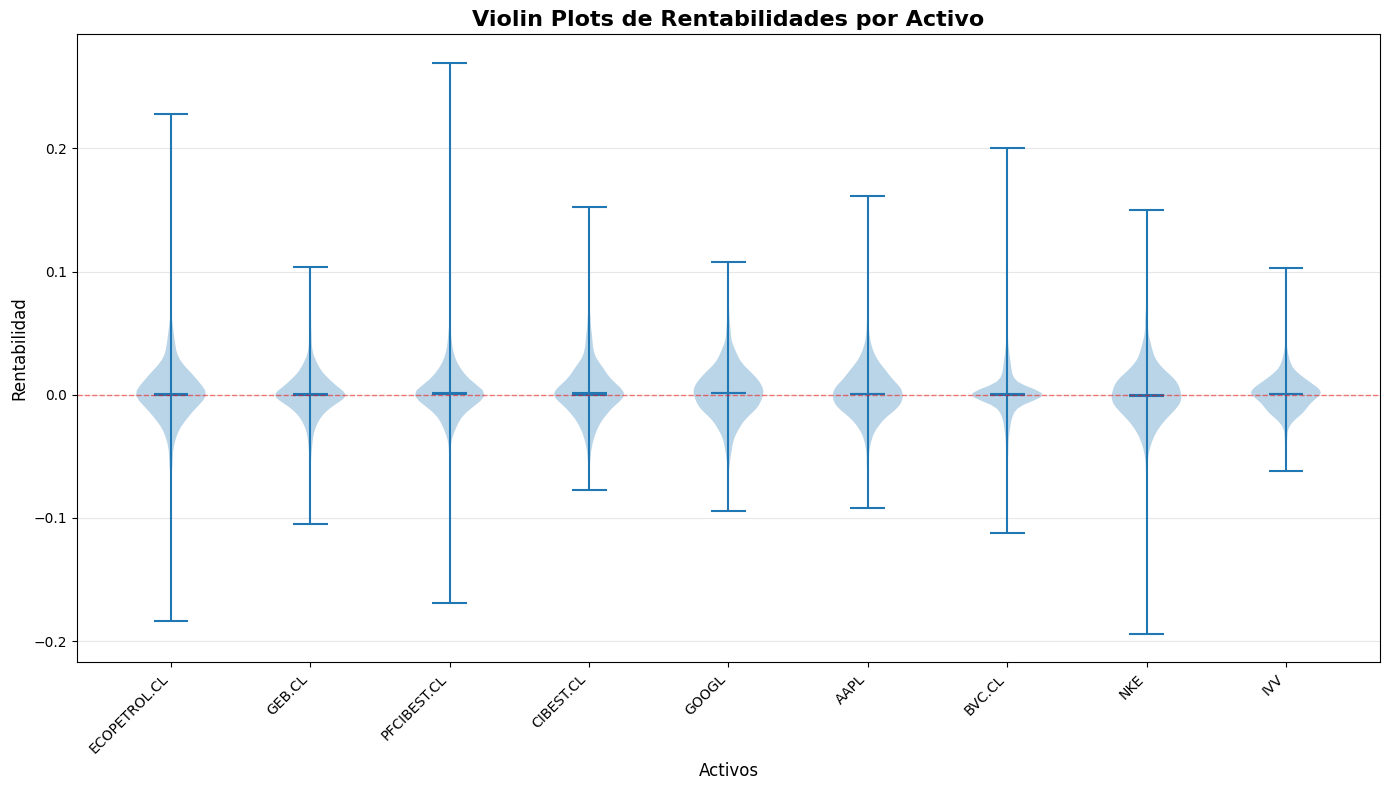

In [11]:
# Violin plots de las distribuciones de rentabilidades
fig, ax = plt.subplots(figsize=(14, 8))

# Preparar datos para violin plot
data_for_violin = [stock_returns[col].dropna() for col in stock_returns.columns]

# Crear violin plot
parts = ax.violinplot(data_for_violin, positions=range(len(stock_returns.columns)), 
                      showmeans=True, showmedians=True)

# Configurar etiquetas
ax.set_xticks(range(len(stock_returns.columns)))
ax.set_xticklabels(stock_returns.columns, rotation=45, ha='right')
ax.set_title('Violin Plots de Rentabilidades por Activo', fontsize=16, fontweight='bold')
ax.set_ylabel('Rentabilidad', fontsize=12)
ax.set_xlabel('Activos', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

In [12]:
portfolio_data = {
    "ECOPETROL.CL": 9006,
    "GEB.CL": 308,
    "PFCIBEST.CL": 20,
    "CIBEST.CL": 39,
    "GOOGL": 7,
    "AAPL": 7,
    "BVC.CL": 154,
    "NKE": 17,
    "IVV": 5
}

In [13]:
pesos = calcular_pesos(portfolio_data=portfolio_data, stock_prices=data_stock)
print(pesos)


{'ECOPETROL.CL': 0.33572635360894937, 'GEB.CL': 0.01580692559543473, 'PFCIBEST.CL': 0.024034997028659556, 'CIBEST.CL': 0.057091628919351385, 'GOOGL': 0.13361665513065954, 'AAPL': 0.11179009469367825, 'BVC.CL': 0.04115567692343702, 'NKE': 0.06700750093755585, 'IVV': 0.21377016716227432}


In [14]:
pesos_array = np.array([pesos[ticker] for ticker in stock_returns.columns])
print(pesos_array)

[0.33572635 0.01580693 0.024035   0.05709163 0.13361666 0.11179009
 0.04115568 0.0670075  0.21377017]


In [15]:
rentabilidad_esperada = retorno_esperado_portafolio(stock_returns, pesos_array) 
# Aplicamos la fórmula de capitalización compuesta
rentabilidad_anualizada = ((1 + rentabilidad_esperada) ** 252) - 1

print(f"Rentabilidad anual esperada (Geométrica): {rentabilidad_anualizada * 100:.2f}%")

Rentabilidad anual esperada (Geométrica): 23.24%


<Figure size 1200x800 with 0 Axes>

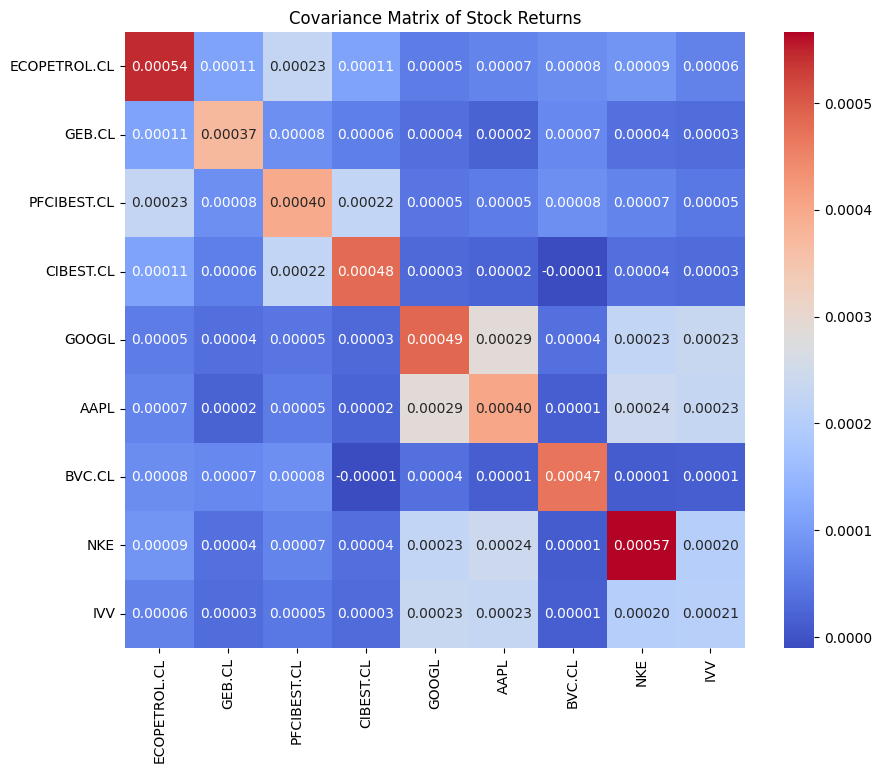

In [16]:
cov = obtener_covarianza(stock_returns)

plt.figure(figsize=(12, 8))
plt.figure(figsize=(10,8))

sns.heatmap(cov, annot=True, fmt=".5f", cmap='coolwarm')

plt.title('Covariance Matrix of Stock Returns')
plt.show()

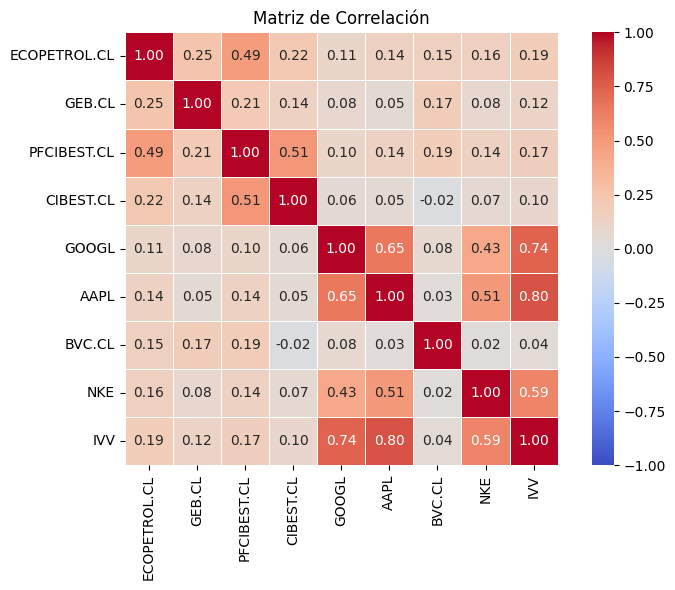

In [17]:
std_devs = np.sqrt(np.diag(cov))           # desviaciones estándar
corr_matrix = cov / np.outer(std_devs, std_devs)

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,          # mostrar valores numéricos
    fmt=".2f",           # 2 decimales
    cmap="coolwarm",     # escala de color azul-rojo
    vmin=-1, vmax=1,     # rango fijo [-1, 1]
    square=True,
    linewidths=0.5
)
plt.title("Matriz de Correlación")
plt.tight_layout()
plt.show()

In [18]:
varianza_p = obtener_varianza_portafolio(pesos_array, cov)
volatilidad_p = np.sqrt(varianza_p)
print(f"Volatilidad diaria del portafolio: {volatilidad_p * 100:.2f}%")
volatilidad_p_anual = volatilidad_p * np.sqrt(252)

# Imprimimos el resultado
print(f"Volatilidad anual esperada (Riesgo): {volatilidad_p_anual * 100:.2f}%")

Volatilidad diaria del portafolio: 1.33%
Volatilidad anual esperada (Riesgo): 21.04%


In [25]:

def frontera_eficiente(stock_returns, Omega):
    r_bar = np.mean(stock_returns, axis=0)
    n = len(r_bar)
    ones = np.ones(n)

    # --- Build augmented matrix (n+2 x n+2) ---
    # [Ω    r̄    1]   [w    ]   [0]
    # [r̄ᵀ   0    0] * [λ₁/2 ] = [r_p^(k)]
    # [1ᵀ   0    0]   [λ₂/2 ]   [1]

    A = np.zeros((n+2, n+2))
    A[:n, :n] = Omega
    A[:n, n] = r_bar
    A[:n, n+1] = ones
    A[n, :n] = r_bar
    A[n+1, :n] = ones

    # --- Solve for each target return ---
    # First find minimum variance portfolio to know the inflection point
    A_min = np.zeros((n+1, n+1))
    A_min[:n, :n] = Omega
    A_min[:n, n] = ones
    A_min[n, :n] = ones
    b_min = np.zeros(n+1)
    b_min[n] = 1
    sol_min = np.linalg.solve(A_min, b_min)
    w0 = sol_min[:n]
    r_min = w0 @ r_bar
    sigma_min = np.sqrt(w0 @ Omega @ w0)
    print(f"Min variance portfolio: r={r_min*100:.4f}%, σ={sigma_min*100:.4f}%\n")

    # Efficient frontier: solve eq [11] for r_p^(k) > r_min
    target_returns = np.linspace(r_min, 0.004, 20)

    print(f"{'r_p (%)':>10} {'σ_p (%)':>10} {'w1':>8} {'w2':>8} {'w3':>8} {'w4':>8} {'w5':>8}")
    print("-" * 74)

    frontier = []
    for r_k in target_returns:
        b = np.zeros(n+2)
        b[n] = r_k      # target return
        b[n+1] = 1.0    # weights sum to 1
        
        sol = np.linalg.solve(A, b)
        w = sol[:n]
        
        sigma_p = np.sqrt(w @ Omega @ w)
        r_p = w @ r_bar
        
        frontier.append((sigma_p, r_p))
        print(f"{r_p*100:10.4f} {sigma_p*100:10.4f} {w[0]:8.4f} {w[1]:8.4f} {w[2]:8.4f} {w[3]:8.4f} {w[4]:8.4f}")

Estamos printeando solo los 5 primeros pesos...

In [26]:
frontera_eficiente(stock_returns, cov)

Min variance portfolio: r=0.0799%, σ=1.0181%

   r_p (%)    σ_p (%)       w1       w2       w3       w4       w5
--------------------------------------------------------------------------
    0.0799     1.0181   0.0348   0.1637   0.0371   0.1451  -0.0704
    0.0968     1.0435   0.0305   0.1476   0.0623   0.1752   0.0162
    0.1136     1.1160   0.0263   0.1314   0.0874   0.2053   0.1028
    0.1305     1.2275   0.0221   0.1153   0.1126   0.2354   0.1894
    0.1473     1.3684   0.0178   0.0991   0.1378   0.2655   0.2760
    0.1642     1.5306   0.0136   0.0830   0.1629   0.2956   0.3627
    0.1810     1.7081   0.0093   0.0668   0.1881   0.3256   0.4493
    0.1979     1.8965   0.0051   0.0506   0.2132   0.3557   0.5359
    0.2147     2.0929   0.0009   0.0345   0.2384   0.3858   0.6225
    0.2315     2.2954  -0.0034   0.0183   0.2636   0.4159   0.7091
    0.2484     2.5023  -0.0076   0.0022   0.2887   0.4460   0.7957
    0.2652     2.7127  -0.0119  -0.0140   0.3139   0.4760   0.8823
    0.28